This notebook prompts all 4 of @gfodor's pixelart loras in parallel. (It is similar to the previous two notebooks.)

In [1]:
import torch
from diffusers import AutoPipelineForText2Image
from concurrent.futures import ProcessPoolExecutor, as_completed

def init_pipe(model_id, adapter_id, gpu_index):
    print(f"Initializing {model_id} with {adapter_id} on GPU {gpu_index}.\n")
    pipe = AutoPipelineForText2Image.from_pretrained(model_id)
    pipe.to(f"cuda:{gpu_index}")
    pipe.load_lora_weights(adapter_id)
    pipe.fuse_lora()
    return pipe

def generate_image(pipe, prompt):
    return pipe(prompt=prompt, num_inference_steps=60, guidance_scale=5).images[0]

init_args = [
    # model_id, adapter_id, gpu_index
    ("segmind/SSD-1B", "gfodor/bigp1xart-ssd-1b-flat-256x256", 0),
    ("segmind/SSD-1B", "gfodor/bigp1xart-ssd-1b-detailed-256x256", 1),
    ("segmind/Segmind-Vega", "gfodor/bigp1xart-vega-detailed-256x256", 2),
    ("segmind/Segmind-Vega", "gfodor/bigp1xart-vega-flat-256x256", 3),
]

pipes = []
with ProcessPoolExecutor() as executor:
    future_pipes = [executor.submit(init_pipe, *args) for args in init_args]
    for future in as_completed(future_pipes):
        pipes.append(future.result())

Initializing segmind/SSD-1B with gfodor/bigp1xart-ssd-1b-flat-256x256 on GPU 0.
Initializing segmind/Segmind-Vega with gfodor/bigp1xart-vega-detailed-256x256 on GPU 2.
Initializing segmind/SSD-1B with gfodor/bigp1xart-ssd-1b-detailed-256x256 on GPU 1.
Initializing segmind/Segmind-Vega with gfodor/bigp1xart-vega-flat-256x256 on GPU 3.






Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed down. We assume it will never going to be the case, but if it is, please file but to https://github.com/pytorch/pytorch
[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed down. We assume it will never going to be the case, but if it is, please file but to https://github.com/pytorch/pytorch
[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed down. We assume it will never going to be the case, but if it is, please file but to https://github.com/pytorch/pytorch
[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed 

In [2]:
print(len(pipes))

4


In [5]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to generate images within threads
def generate_image_thread(pipe, prompt):
    return pipe(prompt=prompt, num_inference_steps=60, guidance_scale=5).images[0]

# Now, use the pipes for image generation with threads
prompt = "bigp1xart A scenic landscape with mountains"

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(generate_image_thread, pipe, prompt) for pipe in pipes]
    images = [future.result() for future in as_completed(futures)]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

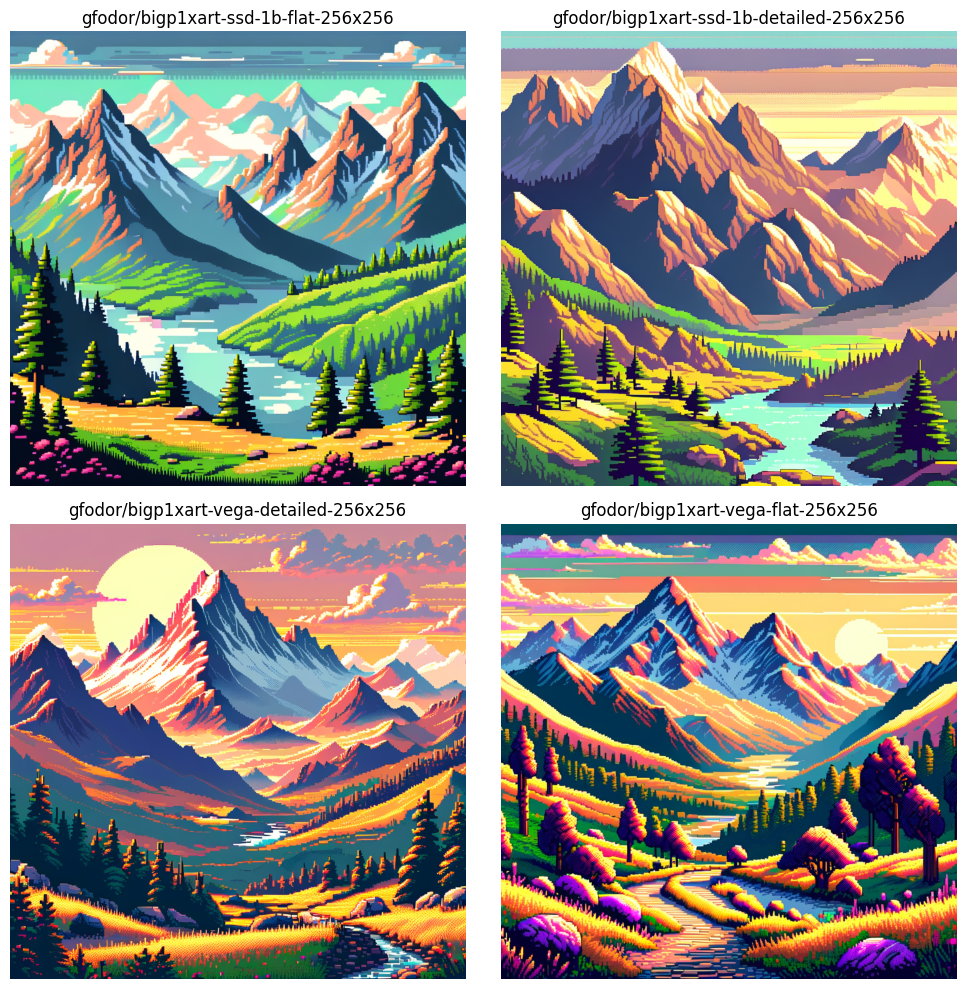

In [6]:
import matplotlib.pyplot as plt

# Assuming 'images' is a list of PIL Image objects and corresponds to the order in 'init_args'
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for (model_id, adapter_id, gpu_index), img, ax in zip(init_args, images, axs):
    ax.imshow(img)
    ax.set_title(adapter_id)  # Set the title of each subplot to the adapter_id
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()